In [8]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle    

# EVALUATE MODEL YOLO11N

## 1. LOAD MODEL

In [2]:
# Xac dinh vi tri thu muc du an
ROOT = os.path.dirname(os.path.abspath(os.getcwd()))   
print(ROOT)

d:\DFA_Behavior_Shopping_Detection


In [3]:
# Xac dinh duong dan den thu muc models
models_path = os.path.join(ROOT, "models") 
print(models_path)

d:\DFA_Behavior_Shopping_Detection\models


In [4]:
# load a pretrained model (recommended for training)
model = YOLO(os.path.join(models_path, "yolo11n.pt"))  

In [10]:
INPUT_IMAGE_PATH = os.path.join(ROOT, "asesrt", "sample.jpg")       
INPUT_VIDEO_PATH = os.path.join(ROOT, "asesrt", "sample.mp4")     

## 2. EVALUATE ON IMAGE

In [12]:
# Nhan dien con nguoi tren anh 
results = model.predict(
    source=INPUT_IMAGE_PATH, 
    conf=0.25, 
    save=True, 
    save_conf=False,
    device='cpu' # Bỏ comment nếu bạn không có GPU
)


image 1/1 d:\DFA_Behavior_Shopping_Detection\asesrt\sample.jpg: 384x640 20 persons, 202.7ms
Speed: 6.7ms preprocess, 202.7ms inference, 9.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to D:\Generative_model\runs\detect\predict3



--- Kết quả Detection ---
Số lượng vật thể được phát hiện: 20
Danh sách vật thể:
  1. person (Confidence: 0.72)
  2. person (Confidence: 0.69)
  3. person (Confidence: 0.69)
  4. person (Confidence: 0.68)
  5. person (Confidence: 0.65)
  6. person (Confidence: 0.60)
  7. person (Confidence: 0.56)
  8. person (Confidence: 0.54)
  9. person (Confidence: 0.52)
  10. person (Confidence: 0.52)
  11. person (Confidence: 0.51)
  12. person (Confidence: 0.50)
  13. person (Confidence: 0.45)
  14. person (Confidence: 0.44)
  15. person (Confidence: 0.44)
  16. person (Confidence: 0.42)
  17. person (Confidence: 0.35)
  18. person (Confidence: 0.32)
  19. person (Confidence: 0.31)
  20. person (Confidence: 0.30)


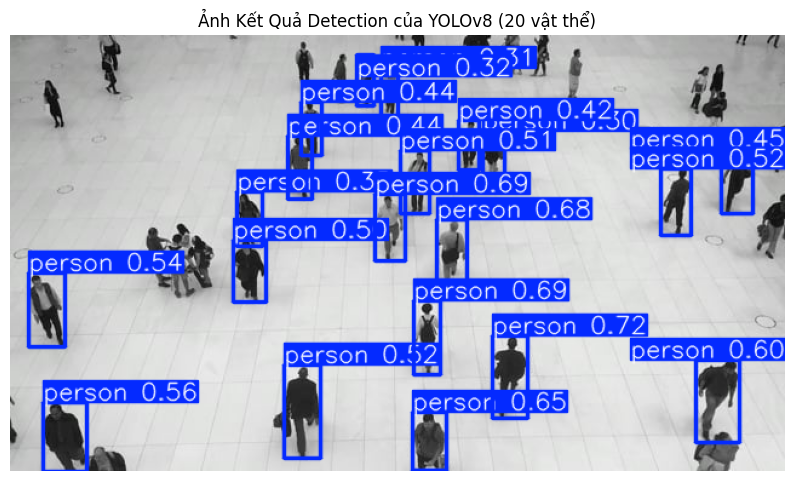

In [13]:
print("\n--- Kết quả Detection ---")

# 4. Xử lý và Hiển thị kết quả
if results and len(results) > 0:
    # Lấy ra kết quả của ảnh đầu tiên (vì chúng ta chỉ chạy 1 ảnh)
    result = results[0]
    
    # 4a. In thông tin về các vật thể được phát hiện
    boxes = result.boxes
    print(f"Số lượng vật thể được phát hiện: {len(boxes)}")
    print("Danh sách vật thể:")
    for i, box in enumerate(boxes):
        class_id = int(box.cls[0].item())  # Lấy ID của class
        conf = float(box.conf[0].item())  # Lấy Confidence
        class_name = model.names[class_id] # Lấy tên class
        print(f"  {i+1}. {class_name} (Confidence: {conf:.2f})")

    # 4b. Hiển thị ảnh đã được vẽ bounding box
    # result.plot() trả về mảng NumPy của ảnh đã vẽ (ở định dạng BGR)
    im_bgr = result.plot() 
    # Chuyển từ BGR sang RGB cho Matplotlib hiển thị màu sắc đúng
    im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB) 

    plt.figure(figsize=(10, 8))
    plt.imshow(im_rgb)
    plt.title(f"Ảnh Kết Quả Detection của YOLOv8 ({len(boxes)} vật thể)")
    plt.axis('off')
    plt.show()

else:
    print("Không tìm thấy kết quả detection nào.")


## 3. REGION OF INTEREST

Grid: 4 rows x 6 cols

--- Grid counts (rows x cols) ---
[[0 0 3 0 0 0]
 [0 1 2 3 0 2]
 [1 1 0 2 0 0]
 [1 0 1 2 0 1]]


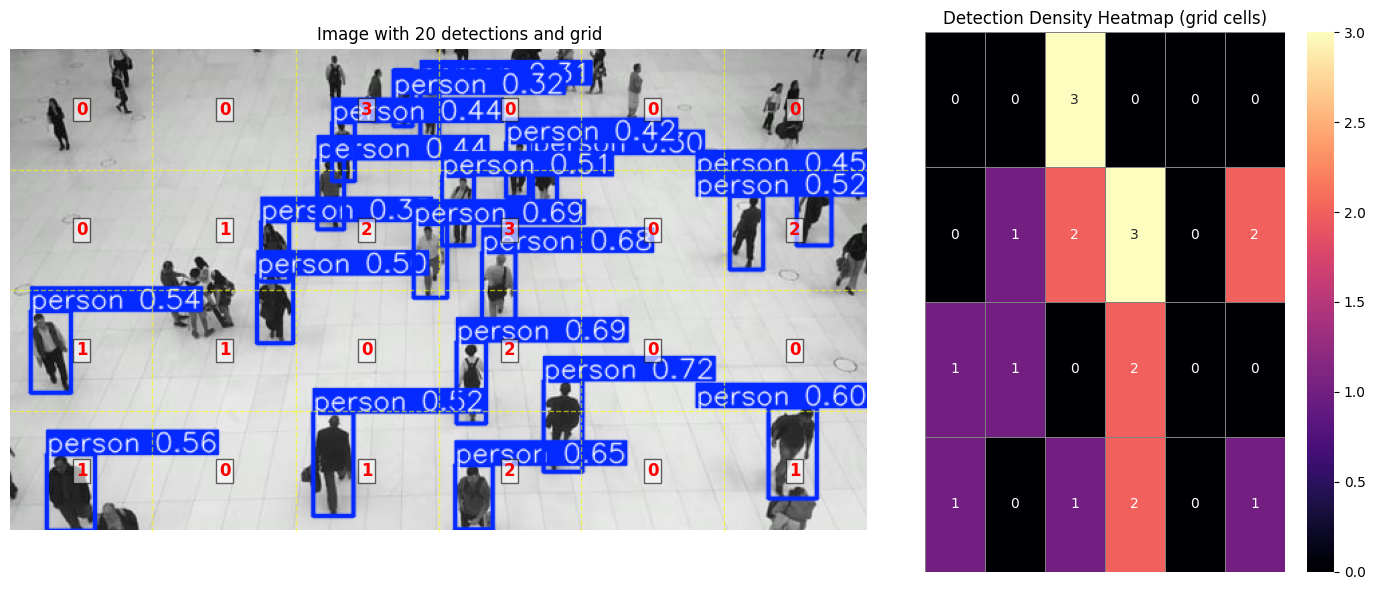

In [ ]:
import seaborn as sns
# Grid-based density counting: chia ảnh thành lưới và tính số object trong mỗi ô
# Tham số lưới: thay đổi rows/cols để điều khiển độ phân giải của vùng nhận diện
grid_rows = 4  # số hàng của lưới
grid_cols = 6  # số cột của lưới
# Margin để hiển thị nhãn/heatmap nếu cần
pad_right = 300  # px để dành cho heatmap bên phải

print(f"Grid: {grid_rows} rows x {grid_cols} cols")

# Đếm số lượng vật thể trong từng ô lưới
if results and len(results) > 0:
    
    # Lấy ra kết quả của ảnh đầu tiên (vì chúng ta chỉ chạy 1 ảnh)
    result = results[0]
    
    # Lấy các bounding boxes
    boxes = result.boxes
    im_bgr = result.plot()  # ảnh đã vẽ bounding box (BGR)
    im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
    h, w = im_rgb.shape[:2]

    # Kích thước mỗi ô
    cell_w = w / grid_cols
    cell_h = h / grid_rows

    # Ma trận đếm (rows x cols)
    grid_counts = np.zeros((grid_rows, grid_cols), dtype=int)

    # Lưu tâm các detection để vẽ lên ảnh sau
    centers = []

    # Lấy tâm mỗi hộp và tăng counter ô tương ứng
    for i, box in enumerate(boxes):
        box_coords = box.xyxy[0].cpu().numpy()  # [x_min, y_min, x_max, y_max]
        x_center = (box_coords[0] + box_coords[2]) / 2
        y_center = (box_coords[1] + box_coords[3]) / 2
        centers.append((x_center, y_center))
        col = int(x_center // cell_w)
        row = int(y_center // cell_h)
        # bảo đảm không vượt ra ngoài chỉ mục do làm tròn
        col = min(max(col, 0), grid_cols - 1)
        row = min(max(row, 0), grid_rows - 1)
        grid_counts[row, col] += 1

    print("\n--- Grid counts (rows x cols) ---")
    print(grid_counts)

    # Vẽ ảnh + lưới và chỉ số trên ảnh, đồng thời vẽ heatmap bên cạnh
    fig, (ax_img, ax_heat) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 0.5]})

    # Hiển thị ảnh gốc với bounding boxes
    ax_img.imshow(im_rgb)
    ax_img.axis('off')

    # Vẽ lưới lên ảnh
    for r in range(1, grid_rows):
        y = int(r * cell_h)
        ax_img.plot([0, w], [y, y], color='yellow', linewidth=1, linestyle='--', alpha=0.6)
    for c in range(1, grid_cols):
        x = int(c * cell_w)
        ax_img.plot([x, x], [0, h], color='yellow', linewidth=1, linestyle='--', alpha=0.6)

    # Vẽ tâm mỗi detection lên ảnh (chấm nhỏ và label index)
    if len(centers) > 0:
        xs = [c[0] for c in centers]
        ys = [c[1] for c in centers]
        ax_img.scatter(xs, ys, c='blue', s=30, edgecolors='white', linewidths=0.7, zorder=3)
        for idx, (cx_box, cy_box) in enumerate(centers):
            ax_img.text(cx_box + 4, cy_box - 4, str(idx+1), color='white', fontsize=8, weight='bold', zorder=4,
                        bbox=dict(facecolor='black', alpha=0.5, pad=1, edgecolor='none'))

    # Viết số lượng vào giữa mỗi ô
    for r in range(grid_rows):
        for c in range(grid_cols):
            cx = int((c + 0.5) * cell_w)
            cy = int((r + 0.5) * cell_h)
            count = grid_counts[r, c]
            ax_img.text(cx, cy, str(count), color='red', fontsize=12, fontweight='bold',
                         ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6, pad=2))

    ax_img.set_title(f'Image with {len(boxes)} detections and grid')

    # Vẽ heatmap (density) trên ax_heat
    sns.heatmap(grid_counts, ax=ax_heat, annot=True, fmt='d', cmap='magma', cbar=True,
                xticklabels=False, yticklabels=False, linewidths=0.5, linecolor='gray')
    ax_heat.set_title('Detection Density Heatmap (grid cells)')

    plt.tight_layout()
    plt.show()
else:
    print("Không tìm thấy kết quả detection nào.")

In [26]:
def count_in_roi(boxes, image_shape, grid_cols=6, grid_rows=4, pad_right=300):
    """ 
    Đếm số lượng vật thể trong Vùng Quan Tâm (ROI) được xác định bởi lưới.  
    boxes: danh sách các bounding boxes từ YOLO
    image_shape: kích thước ảnh (h, w, c)
    grid_cols, grid_rows: số cột và hàng của lưới
    pad_right: khoảng trống bên phải để vẽ heatmap (nếu có)
    """
    
    h, w = image_shape[:2]
    
    cell_w = w / grid_cols  # chiều rộng mỗi ô  
    cell_h = h / grid_rows  # chiều cao mỗi ô
    
    # Ma trận đếm (rows x cols)
    grid_counts = np.zeros((grid_rows, grid_cols), dtype=int)   
    
    # Lấy tâm mỗi hộp và tăng counter ô tương ứng
    for i, box in enumerate(boxes):
        box_coords = box.xyxy[0].cpu().numpy()  # [x_min, y_min, x_max, y_max]
        x_center = (box_coords[0] + box_coords[2]) / 2
        y_center = (box_coords[1] + box_coords[3]) / 2
        col = int(x_center // cell_w)
        row = int(y_center // cell_h)
        # bảo đảm không vượt ra ngoài chỉ mục do làm tròn
        col = min(max(col, 0), grid_cols - 1)
        row = min(max(row, 0), grid_rows - 1)
        grid_counts[row, col] += 1
    
    return grid_counts

## 3. BEHAVIOR CLASSIFICATION